In [1]:
# IMPORT LIBRARIES

import torch
import sak
import pickle
import cv2
import sak.torch.image.data
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pydicom
import sak
import glob
import os.path
import src.load_data
import scipy as sp
import math
import skimage.transform
import sak.torch.image.data.augmentation
from skimage import metrics
import sklearn.metrics


### pista: podria hacer primero todas las modificaciones y guardar los datos, y luego simplemente ir calculando las metricas con las masks ya hechas, asi se satura menos la cpu

# ACUERDATE: HAY QUE CAMBIAR EL LINE_WIDTH I LA MASK SI HACE FALTA

In [20]:
### FUNCTIONS

def create_mask_init(x, gt_x, gt_y, yref):
    '''
    Create the binary mask from the reference line to the curve.
    '''
    # CREATE MASK AND TILE
    min_size_x = 512
    window = 4
    sigma = 1.0

    mask = np.zeros(x.shape[:2],dtype=bool)
    for ix,iy in zip(gt_x,gt_y):
        ix,iy = int(round(ix)),int(round(iy)) # map to int (pixel position)
        if iy > yref:
            if yref < 0: # No reference line is depicted in the image
                mask[:iy,ix] = 1
            else:        # Current pixel above the reference line
                mask[yref:iy,ix] = 1
        elif iy < yref:  # Current pixel below the reference line
            mask[iy:yref,ix] = 1
        else:            # Current pixel  *IN* the reference line
            mask[iy,ix] = 1
        
    
    #                                                                       #
    ####################### CHOOSING A REPRESENTATION #######################

    # Crop image and ground truth so that it only represents GT span
    doppler_cropped         = x[:,gt_x]
    mask_cropped            =    mask[:,gt_x]

    # Repeat alongside x axis (2nd dimension to have at least min_size_x size)
    try:
        repetitions      = math.ceil(min_size_x/doppler_cropped.shape[1])
        envelope_y_tiled = np.concatenate(     [gt_y]*repetitions)
        mask_tiled       = np.concatenate(   [mask_cropped]*repetitions,axis=1)
        doppler_tiled    = np.concatenate([doppler_cropped]*repetitions,axis=1)
    except ZeroDivisionError:
        pass

    # Apply gaussian filter to smooth borders of tiling
    size_fundamental = doppler_tiled.shape[1]//repetitions
    locations = [(i+1)*size_fundamental-1 for i in range(repetitions-1)]
    for loc in locations:
        onset = loc-window+1
        offset = loc+window
        doppler_tiled[:,onset:offset] = sp.ndimage.gaussian_filter1d(
            doppler_tiled[:,onset:offset],sigma,axis=1
        )

    return doppler_tiled, mask_tiled, mask

def create_mask(x, gt_x, gt_y, line_width):
    '''
    Create the binary mask from the GT, OJO with the line_width
    '''
    # CREATE MASK AND TILE
    min_size_x = 512
    window = 4
    sigma = 1.0

    # Boolean mask from the reference line to the curve position            #

    mask = np.zeros(x.shape[:2],dtype=bool)

    gt_x_full = gt_x.copy()
    gt_y_full = gt_y.copy()
    for i in range(gt_x.shape[0]-1):
        if gt_y[i+1]>gt_y[i]:
            s = 1
        else:
            s = -1
        for y in range(gt_y[i]+1,gt_y[i+1],s):
            gt_x_full = np.insert(gt_x_full,i+1,gt_x[i])
            gt_y_full = np.insert(gt_y_full,i+1,y)
    for i in range(-line_width//2,line_width//2):
        for j in range(-line_width//2,line_width//2):
            try:
                mask[gt_y_full+i,gt_x_full+j] = 1
            except IndexError:
                continue
    
    #                                                                       #
    ####################### CHOOSING A REPRESENTATION #######################

    # Crop image and ground truth so that it only represents GT span
    doppler_cropped         = x[:,gt_x]
    mask_cropped            =    mask[:,gt_x]

    # Repeat alongside x axis (2nd dimension to have at least min_size_x size)
    try:
        repetitions      = math.ceil(min_size_x/doppler_cropped.shape[1])
        envelope_y_tiled = np.concatenate(     [gt_y]*repetitions)
        mask_tiled       = np.concatenate(   [mask_cropped]*repetitions,axis=1)
        doppler_tiled    = np.concatenate([doppler_cropped]*repetitions,axis=1)
    except ZeroDivisionError:
        pass

    # Apply gaussian filter to smooth borders of tiling
    size_fundamental = doppler_tiled.shape[1]//repetitions
    locations = [(i+1)*size_fundamental-1 for i in range(repetitions-1)]
    for loc in locations:
        onset = loc-window+1
        offset = loc+window
        doppler_tiled[:,onset:offset] = sp.ndimage.gaussian_filter1d(
            doppler_tiled[:,onset:offset],sigma,axis=1
        )

    return doppler_tiled, mask_tiled, mask

def interpolar_crop(x, mask_tiled, doppler_tiled):

    # hay que interpolar, es decir recortar el eje x para que al hacer reshape no se distorsione
    shape = (256,512)
    # quiero que sea 256x512
    proporcion = shape[1] // shape[0]
    x_side = x.shape[0]*proporcion
    doppler_tiled_side = doppler_tiled.shape[0]*proporcion
    mask_tiled_side = mask_tiled.shape[0]*proporcion
    

    # cropping:
    x = x[:,0:x_side]
    x = cv2.resize(x,(512,256))[None,]
    x = x.squeeze()

    doppler_tiled = doppler_tiled[:,0:doppler_tiled_side]
    doppler_tiled = cv2.resize(doppler_tiled,(512,256))[None,]
    doppler_tiled = doppler_tiled.squeeze()

    mask_tiled = mask_tiled[:,0:mask_tiled_side]
    mask_tiled = skimage.transform.resize(mask_tiled,(256,512))[None,]
    mask_tiled = mask_tiled.squeeze()

    return x, doppler_tiled, mask_tiled

def get_output(x, model):

    x_torch = torch.tensor(x)[None,None]

    inputs = {'x' : x_torch.float()}

    sak.torch.image.data.augmentation.RescaleIntensity(inputs)

    with torch.no_grad():
        output = model(inputs)
        out_numpy = output['sigmoid'].cpu().detach().numpy().squeeze()

        return out_numpy[2,:,:]

### METRICS

def dice(inputs, targets, smooth=1):
    #flatten label and prediction tensors
    inputs = inputs.flatten()
    targets = targets.flatten()
    
    intersection = (inputs * targets).sum()
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
    return dice

# Hausdorff distance --> skimage.metrics.hausdorff_distance(img1, img2)

# RMSE (convertir mask en curve)

def mask_to_curve(mask):
    '''
    De momento esto se lo aplico tanto a la prediction como al target, 
    de esta forma obtengo las 2 curvas y luego calculo la metrica.

    Se podria intentar usar envelope_y_tiled como target pero hay que hacer
    transformaciones en 1d y no se puede.
    '''

    vector = np.empty([0])
    indexes = np.empty([0])

    for i in range(mask.shape[1]):
        col = mask[:,i]
        for idx, val in enumerate(col):
            if val == 1.:
                indexes = np.append(indexes, idx)

        # en caso que este vacia la columna, o se pone el valor anterior o se pone 0 si es al principio
        if indexes.size == 0:
            try:
                indexes = np.append(indexes, vector[-1])
            except IndexError:
                indexes = np.append(indexes, 0)
        vector = np.append(vector, indexes.mean())

        indexes = np.empty([0])
    
    return vector

rmse = torch.nn.MSELoss()
    

In [27]:
# LOAD THE MODEL

model = torch.load('C:/Users/hp240/Documents/IAGO/EBM/TFG/TrainedModels/24_def/model_best.model')
model.state_dict()
model.eval()

ModelWrapper(
  (operation): unet(
    (basenet): basenet(
      (e0): encoder_block(
        (conv): conv_block(
          (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu0): LeakyReLU(negative_slope=0.01)
          (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout0): Dropout2d(p=0.25, inplace=False)
          (relu1): LeakyReLU(negative_slope=0.01)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout1): Dropout2d(p=0.25, inplace=False)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      )
      (e1): encoder_block(
        (conv): conv_block(
          (conv0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu0): LeakyReLU(negative_slope=0.01)
          (bn0): BatchNorm2d(64, 

In [28]:
# LOAD TEST SET
with open("C:/Users/hp240/Documents/IAGO/EBM/TFG/TrainedModels/24_def/execution_info.pkl", "rb") as f:
    keys_test = pickle.load(f)["keys_test"]

In [29]:
# LOAD DATA FROM TEST SET

datadir = 'C:\\Users\\hp240\\Documents\\IAGO\\EBM\\TFG\\ALL_DOPPLER\\'

curves_x = sak.load_data(os.path.join(datadir,"x_coordinates.csv"))
curves_y = sak.load_data(os.path.join(datadir,"y_coordinates.csv"))

data = [datadir+i for i in keys_test]
curves_x_test = {i:curves_x[i] for i in keys_test}
curves_y_test = {i:curves_y[i] for i in keys_test}


dice_list = np.empty([0])
haus_list = np.empty([0])
rmse_list = np.empty([0])

data_2 = data[:1]
i=0
for image in data:

    dicom = pydicom.dcmread(image)

    x0,x1,y0,y1,xref,yref,deltax,deltay,unitsx,unitsy = src.load_data.get_frame(dicom,"doppler")

    x = dicom.pixel_array.copy()[y0:y1,x0:x1,]
    if dicom.get("PhotometricInterpretation", "RGB") in ['YBR_FULL', 'YBR_FULL_422']:
        x = src.load_data.convert_ybr_to_rgb(x)
    x = x[...,0] # to grayscale
    gt_x = curves_x_test[dicom.SOPInstanceUID] -x0
    gt_y = curves_y_test[dicom.SOPInstanceUID]

    doppler_tiled, mask_tiled, mask = create_mask(x, gt_x, gt_y, line_width = 40)
    #doppler_tiled, mask_tiled, mask = create_mask_init(x, gt_x, gt_y, yref=yref)
    x, doppler_tiled_2, mask_tiled_2 = interpolar_crop(x, mask_tiled, doppler_tiled)
    out_numpy = get_output(x, model)
    out_numpy_curve = mask_to_curve(out_numpy)
    mask_tiled_2_curve = mask_to_curve(mask_tiled_2)



    dice_list = np.append(dice_list, dice(out_numpy, mask_tiled_2, smooth=1))
    haus_list = np.append(haus_list, metrics.hausdorff_distance(out_numpy, mask_tiled_2))
    rmse_list = np.append(rmse_list, np.sqrt(rmse(torch.Tensor(out_numpy_curve), torch.Tensor(mask_tiled_2_curve))))

    print(i)
    i+=1

np.mean(dice_list) , np.mean(haus_list), np.mean(rmse_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(0.38333541319025305, 101.77876045003754, 43.40703469586962)

In [10]:
# COMPUTE METRICS --> de momento no lo hacemos asi

dice_list = np.empty([0])
haus_list = np.empty([0])
rmse_list = np.empty([0])



dice_list = np.append(dice_list, dice(out_numpy, mask_tiled_2, smooth=1))
haus_list = np.append(haus_list, metrics.hausdorff_distance(out_numpy, mask_tiled_2))
rmse_list = np.append(rmse_list, np.sqrt(rmse(torch.Tensor(out_numpy_curve), torch.Tensor(mask_tiled_2_curve))))

np.mean(dice_list) , np.mean(haus_list), np.mean(rmse_list)

------ 

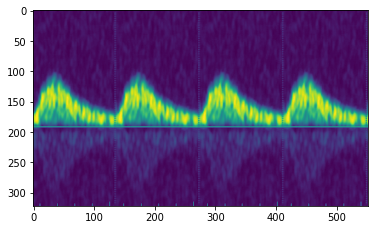

In [35]:
plt.imshow(doppler_tiled)
#plt.savefig('doppler_tiled')

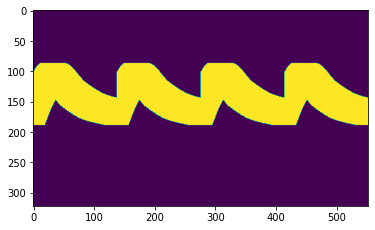

In [40]:
plt.imshow(mask_tiled)
#plt.savefig('mask_tiled_40')

In [6]:
np.sqrt(rmse(torch.Tensor(out_numpy_curve), torch.Tensor(out_numpy_curve)))

tensor(0.)

In [7]:
metrics.hausdorff_distance(out_numpy, out_numpy)

0.0

In [8]:
dice(out_numpy, out_numpy, smooth=1)

0.9970333075983234